# Collaboration and Competition

### 1. Import everything and start the Environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import copy
import numpy as np
from collections import namedtuple, deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

print('Number of agents:', num_agents)
print('Size of each action:', action_size)
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 2. Actor Critic Network


In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units) # Batch Normalization
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn3 = nn.BatchNorm1d(action_size)
        self.reset_parameters()
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state):
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        return torch.tanh(self.bn3(self.fc3(x)))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state, action):
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x) 

### 3. Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.action_size = action_size
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

### 4. Noisy process

In [5]:
class OUNoise:    
    def __init__(self, size, seed, mu=0.0): 
        self.mu = np.ones(size)*0.0
        self.theta = 0.15
        self.sigma = 0.2
        self.seed = random.seed(seed)
        self.size = size
        self.reset()
    def reset(self):
        self.state = copy.copy(self.mu)
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

### 5. Agent

In [6]:
class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.epsilon = 5
        self.t_step = 0
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.noise = OUNoise((num_agents, action_size), random_seed)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    def act(self, states, add_noise):
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += self.epsilon * self.noise.sample()
        return np.clip(actions, -1, 1)
    def step(self, state, action, reward, next_state, done, agent_number):
        self.t_step += 1
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            if self.t_step % UPDATE_EVERY == 0:
                for _ in range(N_UPDATES):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, agent_number)
    def reset(self):
        self.noise.reset()
    def learn(self, experiences, gamma, agent_number):
        states, actions, rewards, next_states, dones = experiences
        # ---------------------------- update critic ---------------------------- #
        actions_next = self.actor_target(next_states)
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # ---------------------------- update actor ---------------------------- #
        actions_pred = self.actor_local(states)
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        self.epsilon = self.epsilon - (1/250)
        if self.epsilon < 0:
            self.epsilon=0
                  
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 6. Training MADDPG

In [7]:
TAU = 1e-2
GAMMA = 0.99
LR_ACTOR = 1e-3
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0 # L2
UPDATE_EVERY = 1
N_UPDATES = 1
ADD_NOISE = True
BATCH_SIZE = 128
BUFFER_SIZE = int(1e6)
n_episodes = 2000
scores_deque = deque(maxlen=100)

scores_max = []
MA = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Agent_1st = Agent(state_size, action_size, 1, random_seed=0)
Agent_2nd = Agent(state_size, action_size, 1, random_seed=0)

for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    scores = np.zeros(num_agents)
    Agent_1st.reset()
    Agent_2nd.reset()
    while True:
        action_1st = Agent_1st.act(states, ADD_NOISE)
        action_2nd = Agent_2nd.act(states, ADD_NOISE)
        actions = np.concatenate((action_1st, action_2nd), axis=0)
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards
        done = env_info.local_done
        Agent_1st.step(states, actions, rewards[0], next_states, done, 0)
        Agent_2nd.step(states, actions, rewards[1], next_states, done, 1)
        scores += rewards
        states = next_states
        if np.any(done):
            break
    scores_deque.append(np.max(scores))
    scores_max.append(np.max(scores))
    MA.append(np.mean(scores_deque))
                
    if i_episode % 10 == 0:
        print('Episode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}'.format(
            i_episode, np.mean(scores_deque), np.max(scores)))

    if np.mean(scores_deque)>=0.5:
        print('\nTarget Score reached in {:d}th episodes.\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))
        torch.save(Agent_1st.actor_local.state_dict(), 'checkpoint_1stActor.pth')
        torch.save(Agent_1st.critic_local.state_dict(), 'checkpoint_1stCritic.pth')
        torch.save(Agent_2nd.actor_local.state_dict(), 'checkpoint_2ndActor.pth')
        torch.save(Agent_2nd.critic_local.state_dict(), 'checkpoint_2ndCritic.pth')
        break

Episode 0	Average Score: 0.000	Max Score: 0.000


C:\Users\user\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Using a target size (torch.Size([128, 2])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 10	Average Score: 0.000	Max Score: 0.000
Episode 20	Average Score: 0.009	Max Score: 0.100
Episode 30	Average Score: 0.012	Max Score: 0.000
Episode 40	Average Score: 0.014	Max Score: 0.000
Episode 50	Average Score: 0.013	Max Score: 0.000
Episode 60	Average Score: 0.013	Max Score: 0.000
Episode 70	Average Score: 0.011	Max Score: 0.000
Episode 80	Average Score: 0.011	Max Score: 0.000
Episode 90	Average Score: 0.012	Max Score: 0.000
Episode 100	Average Score: 0.013	Max Score: 0.100
Episode 110	Average Score: 0.015	Max Score: 0.000
Episode 120	Average Score: 0.018	Max Score: 0.100
Episode 130	Average Score: 0.022	Max Score: 0.090
Episode 140	Average Score: 0.029	Max Score: 0.100
Episode 150	Average Score: 0.036	Max Score: 0.000
Episode 160	Average Score: 0.044	Max Score: 0.100
Episode 170	Average Score: 0.052	Max Score: 0.100
Episode 180	Average Score: 0.060	Max Score: 0.100
Episode 190	Average Score: 0.062	Max Score: 0.000
Episode 200	Average Score: 0.070	Max Score: 0.100
Episode 2

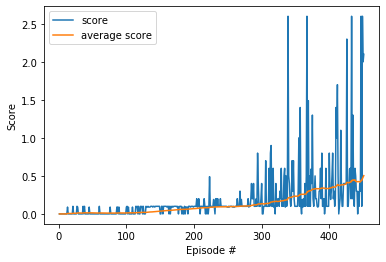

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_max)+1), scores_max, label = 'score')
plt.plot(np.arange(1, len(MA)+1), MA, label = 'average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

### 7. Let's look at the smart agent we trained

In [9]:
Agent_1st.actor_local.load_state_dict(torch.load('checkpoint_1stActor.pth', map_location='cpu'))
Agent_1st.critic_local.load_state_dict(torch.load('checkpoint_1stCritic.pth', map_location='cpu'))
Agent_2nd.actor_local.load_state_dict(torch.load('checkpoint_2ndActor.pth', map_location='cpu'))
Agent_2nd.critic_local.load_state_dict(torch.load('checkpoint_2ndCritic.pth', map_location='cpu'))
env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
states = np.reshape(states, (1,48))

for i in range(200):
    action_1st = Agent_1st.act(states, add_noise=False)         
    action_2nd = Agent_2nd.act(states, add_noise=False)        
    actions = np.concatenate((action_1st, action_2nd), axis=0) 
    actions = np.reshape(actions, (1, 4))                              
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    states = next_states                              
    if np.any(dones):                              
        break

In [10]:
# env.close()

Thank you!